# Chapter 15 - Classifying Images with Deep Convolutional Neural Networks

### Overview

- [Building blocks of convolutional neural networks](#Building-blocks-of-convolutional-neural-networks)
  - [Understanding CNNs and learning feature hierarchies](#Understanding-CNNs-and-learning-feature-hierarchies)
  - [Performing discrete convolutions](#Performing-discrete-convolutions)
    - [Performing a discrete convolution in one dimension](#Performing-a-discrete-convolution-in-one-dimension)
    - [The effect of zero-padding in convolution](#The-effect-of-zero-padding-in-convolution)
    - [Determining the size of the convolution output](#Determining-the-size-of-the-convolution-output)
    - [Performing a discrete convolution in 2D](#Performing-a-discrete-convolution-in-2D)
    - [Sub-sampling](#Sub-sampling)
  - [Putting everything together to build a CNN](#Putting-everything-together-to-build-a-CNN)
    - [Implementing a CNN in Keras](#Implementing-a-deep-convolutional-neural-network-using-Keras)
    - [Loading and preprocessing the data](#Loading-and-preprocessing-the-data)

In [3]:
from IPython.display import Image
%matplotlib inline

# Building blocks of convolutional neural networks 
- Family of models inspired by the visual cortex of the human brain
    - object recognition
- Developed in the earliy 1990
- Important building block in most DNNs for image classification

## Understanding CNNs and learning feature hierarchies
- Extraction of relevant features (1D, 2D, ...)
    - Translational invariant patterns

<img src="./images/CNN_local_patterns.png" alt="Feature map" style="width: 300px;"/>
MNIST letter borrowed from "Deep Learning with Python" (F. Chollet)

### Combining features in a hierarchy
- Low-level features: edges, simple patterns
- High-level features: shapes, objects

<img src="./images/cortex.png" alt="Feature map" style="width: 700px;"/>
Hubel and Wiesel visual cortex experiment

<img src="./images/CNN_cat.png" alt="Feature map" style="width: 700px;"/>
Cat borrowed from "Deep Learning with Python" (F. Chollet)

### Feature map
- Each element is connected to a small patch of pixels
- Weights are shared across all pathes
- Size of filters and step sizes control overlap and size of features
- Number of filters controls the number of features that can be learned
<img src="./images/15_01.png" alt="Feature map" style="width: 700px;"/>

### Parameters
- Each convolutional filter has #parameters = #elements.
  - Banks of filters and a set of input channels increases this.
- Pooling layers: simplify/decrease dimensionality, e.g. with max: no parameters.
- Fully connected layers (multilayer perceptron): #parameters from (IxJ) weight matrix.
- Understanding the complexity will be revisited later.

## Performing discrete convolutions  
Notation:
- Dimension: $\bf{A}_{\it{n_1 \times n_2}}$
- Indexing: $\bf{A}[\it{i,j}\bf{]}$
- Convolutional operator: $\ast$
  - Not to be confused with dot product, matrix product, Hadamard, Kronecker, Khatri-Rao, ...

###  Performing a discrete convolution in one dimension
- (Discrete) 1D convolution between input (signal) $x$ and filter $w$ is defined as:
$$y=x \ast w \rightarrow y[i] = \sum^{+\infty}_{k=-\infty}x[i-k]w[k]$$
- i.e. each element of the output is the product of a subset of the input and each filter coefficient
- Infinities are in practice limited to padding with zeros, e.g. to the size of the filter

<img src="./images/15_02.png" alt="1D convolution" style="width: 700px;"/>

### Convolution with padding:
- Assume input $x$ of size $n$ and filter $w$ of size $m$.
- A padded vector $x^p$ with size $n+2p$ results in the more practical formula:
$$y=x \ast w \rightarrow y[i] = \sum^{k=m-1}_{k=0}x^p[i+m-k]w[k]$$
- Even more practical: Rotate (r, flip) the filter to get a dot product notation which can be repeated like a sliding window:
$$y[i] = x[i:i+m].w^r$$

### Convolution vs Cross-Correlation (1D Example)

Input:  
$x = [x_0, x_1, x_2], \quad w = [w_0, w_1, w_2]$

---

#### 🔹 Convolution (at $i = 2$)

¤ Formula:  
$y[i] = \sum_{k=0}^{2} x[i-k] \cdot w[k]$

| k | Expression        | Substitution |
|---|-------------------|--------------|
| 0 | $x[2-0] \cdot w_0$ | $x_2 w_0$ |
| 1 | $x[2-1] \cdot w_1$ | $x_1 w_1$ |
| 2 | $x[2-2] \cdot w_2$ | $x_0 w_2$ |

¤ Result:  
$y[2] = x_2 w_0 + x_1 w_1 + x_0 w_2$

---




#### 🔹 Cross-Correlation (at $i = 0$)

¤ Formula:  
$y[i] = \sum_{k=0}^{2} x[i+k] \cdot w[k]$

| k | Expression        | Substitution |
|---|-------------------|--------------|
| 0 | $x[0+0] \cdot w_0$ | $x_0 w_0$ |
| 1 | $x[0+1] \cdot w_1$ | $x_1 w_1$ |
| 2 | $x[0+2] \cdot w_2$ | $x_2 w_2$ |

¤ Result:  
$y[0] = x_0 w_0 + x_1 w_1 + x_2 w_2$

---

**Key difference:**  
- Convolution uses $x[i-k]$ → the filter is **flipped**.  
- Cross-correlation uses $x[i+k]$ → the filter is **as-is**.

### Example
- $n=8, m=4, p=0, stride=2$
<img src="./images/15_03.png" alt="1D convolution steps" style="width: 900px;"/>

### The effect of zero-padding in convolution
- Full padding: $p=m-1$, gives equal usage of elements, increases output size.
- Same padding: $p$ and stride combined to achieve equal input and output size (most used in DNN).
- Valid padding: $p=0$, shrinks output and has unequal usage of elements (many layers shrinks too much).
- First two are recommended, possibly together with pooling for downsampling.

<img src="./images/15_11.png" alt="Padding" style="width: 700px;"/> 

### Determining the size of the convolution output
$$o = \left \lfloor{\frac{n+2p-m}{s}}\right \rfloor +1 $$  
  
Example:  
$$n=10,m=5,p=2,s=1$$  
  
$$o = \left \lfloor{\frac{10+2\times2-5}{1}}\right \rfloor +1 = 10$$  
#Input == #Output => "same"

In [1]:
# Naïve 1D convolution:
import numpy as np

def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int(len(x)/s),s):
        res.append(np.sum(x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)

## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]
print('Conv1d Implementation: ', 
      conv1d(x, w, p=2, s=1))
print('Numpy Results:         ', 
      np.convolve(x, w, mode='same'))

Conv1d Implementation:  [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results:          [ 5 14 16 26 24 34 19 22]


Mental arithmetic (aided by paper/computer if needed): Compute the 1st and 4th output manually.  
Discuss/compare with your neigbhour(s).

### Performing a discrete convolution in 2D

<img src="./images/padded_and_output.png" alt="2D convolution" style="width: 700px;"/>

Just like 1D, but in 2D. :-)
- $X_{n_1 \times n_2}$, $W_{m_1 \times m_2}$  
$$Y=X \ast W \rightarrow Y[i,j] = \sum^{+\infty}_{k_1=-\infty}\sum^{+\infty}_{k_2=-\infty}X[i-k_1,j-k_2]W[k_1,k_2]$$  
  
- Zero-padding, filter rotation and strides still apply

### Data: X, Filter: W (un-rotated)
<img src="./images/15_04.png" alt="2D convolution" style="width: 700px;"/>
(next: rotate and move the filter)

- $n_1=3,n_2=3,m_1=3,m_2=3,p=1,s=2$
- Rotated filter: W_rot=W[::-1,::-1]
<img src="./images/15_05.png" alt="2D convolution steps" style="width: 900px;"/>

In [3]:
# Naïve 2D convolution:
import numpy as np
import scipy.signal


def conv2d(X, W, p=(0,0), s=(1,1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1,n2))
    X_padded[p[0]:p[0] + X_orig.shape[0], 
             p[1]:p[1] + X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0], j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))
    
X = [[1, 3, 2, 4], [5, 6, 1, 3], [1 , 2,0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]
print('Conv2d Implementation: \n', 
      conv2d(X, W, p=(1,1), s=(1,1)))

print('Scipy Results:         \n', 
      scipy.signal.convolve2d(X, W, mode='same'))

# Much more efficient solutions are implemented, e.g. in Tensorflow, 
# especially quick for typical filter sizes of 1x1, 3x3, 5x5

Conv2d Implementation: 
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
Scipy Results:         
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


### Convolution filter applied to letter 'o'
<img src="./images/CNN_filter2D.png" alt="Sub-sampling" style="width: 700px;"/>
Response map borrowed from "Deep Learning with Python" (F. Chollet)

## A note on implementation
- In practice filters are not flipped.
  - Tensorflow, PyTorch, ...
- Convolution -> Cross-correlation.
    - Non-flipped filters, otherwise the same
    - Quicker computations, no side-effects for deep learning purposes.

## Sub-sampling
- Max-pooling and mean-pooling (average-pooling)
- $P_{n_1 \times n_2}$, the size of the neighbourhood for pooling
- Introduces robustness to small local changes due to noise or other minor variations.
- Dimensional reduction for higher computational efficency and reduced overfitting.
- Usually non-overlapping, i.e. stride-size = pooling-size, but deviations occur.

<img src="./images/15_06.png" alt="Sub-sampling" style="width: 700px;"/>

### Alternative subsampling by convolution
$$o = \left \lfloor{\frac{n+2p-m}{s}}\right \rfloor +1 $$  
- $n$=input width (e.g. 100)
- $p$=padding
- $m$=filter size
- $s$=stride

# Putting everything together to build a CNN 
- Same building structure as previous NN
    - Convolution as pre-activation ($A = W \ast X + b$ instead of $A = Wx+b$)
    - Activation: $H = \phi(A)$

## Working with multiple input or color channels
- Several layers of $X$:
    - RGB: Rank-3 tensor / three-dimensional array $X_{N_1 \times N_2 \times C_{in}}$
    - Grayscale: $C_{in}=1$
- Images can typically be read in as data type 'uint8' ($2^8=256$ integer values) to save space.

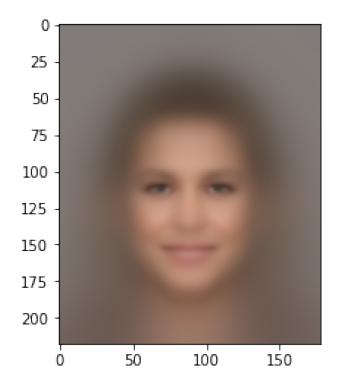

In [5]:
import matplotlib.pyplot as plt

# Read image
img = plt.imread("./example-image.png")

# Show image
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()


In [7]:
print('Image shape:', img.shape)
print('Number of channels:', img.shape[2])
print('Image data type:', img.dtype)

print(img[100:102, 100:102, :])

Image shape: (252, 221, 4)
Number of channels: 4
Image data type: float32
[[[0.7019608  0.5254902  0.43137255 1.        ]
  [0.7137255  0.53333336 0.4392157  1.        ]]

 [[0.7058824  0.5294118  0.43529412 1.        ]
  [0.7137255  0.5372549  0.44313726 1.        ]]]


### Convolution in multiple channels
- Separate kernel per layer
- Convolution per layer, then sum over layers
<img src="./images/CNN_multi1.png" alt="Convolution and pooling" style="width: 800px;"/>

- Multiple feature maps ($W_{m_1 \times m_2 \times C_{in} \times C_{out}}$)
<img src="./images/CNN_multi2.png" alt="Convolution and pooling" style="width: 800px;"/>
### Full story in words:

- **Loop over filters** ($k$)  
- For each filter, **loop over input channels** ($c$)  
- **Convolve** input channel $X[:,:,c]$ with the corresponding kernel slice $W[:,:,c,k]$  
- **Sum** them across all channels → $Y^{Conv}[:,:,k]$  
- **Add bias** $b[k]$  
- **Apply activation** $\phi$  
- Done: one filter produces one feature map


<img src="./images/15_07.png" alt="Convolution and pooling" style="width: 800px;"/>

### Parameter-sharing and sparse-connectivity
- CNN trainable parameters here: $m_1 \times m_2 \times 3 \times 5 + 5$ (last 5 for bias units)
    - No trainable parameter for pooling
    - Input of size $n_1 \times n_2 \times 3$, and assuming mode='same', gives feature map of size $n_1 \times n_2 \times 5$

### Parameter-sharing and sparse-connectivity
- CNN trainable parameters here: $m_1 \times m_2 \times 3 \times 5 + 5$ (last 5 for bias units)
- Corresponding number of parameters with a fully connected layer: $(n_1 \times n_2 \times 3) \times (n_1 \times n_2 \times 5) = (n_1 \times n_2)^2 \times 3 \times 5$

## Regularizing a neural network
- The size of a well-performing network is a challenging problem.
- 'Capacity': level of complexity that can be learned
    - Too small => under fit, cannot learn underlying structure if complex
    - Too large => over fit, perfect learning - bad prediction
- One strategy: overfit sligthly, then regularize
    - L2 regularization
    - Norm constraint on weights (e.g. kernel_constraint=maxnorm(4))
    - Add Gaussian noise to weights
    - Droput


### Dropout

#### Training phase
- Randomly **drop** outputs from hidden units with probability $p_{drop}$ (e.g., $p_{drop}=0.5$).  
- The activations of the remaining units are **scaled up** by a factor of $\tfrac{1}{1-p_{drop}}$  
  (e.g., if $p_{drop}=0.5$, the remaining activations are doubled).  
- This ensures that the expected total contribution of all units stays the same.  
- Forces the network to learn **redundant, distributed representations** instead of relying on specific neurons.  
- Helps prevent overfitting and makes the model more robust.  

#### Testing (inference) phase
- **No units are dropped.**  
- The network uses **all neurons**, but because activations were scaled during training,  
  the output distribution at test time matches what the model saw during training.  

####  Interpretation
- Dropout can be seen as training an **ensemble of many different subnetworks**.  
- The final prediction is effectively an **average over these subnetworks**, improving generalization.  


<img src="./images/15_08.png" alt="Dropout" style="width: 800px;"/>

Filter-wise dropout of convolutions are possible in some implementations, i.e. drop convolution filter instead of weights. If a layer does not affect sizes, layer-dropout is also a possible technique (drop a whole layer), typically in long chains of similar layers.

In [117]:
import numpy as np

# Example hidden layer activations (after applying nonlinearity, e.g., ReLU)
h = np.array([2.0, 4.0, 6.0, 8.0])

# Dropout settings
p_drop = 0.5
keep_prob = 1 - p_drop

# Training phase
mask = (np.random.rand(*h.shape) < keep_prob).astype(float)   # randomly drop
h_dropped = h * mask / keep_prob   # scale survivors by 1/keep_prob

print("Original activations:", h)
print("Dropout mask:", mask)
print("After dropout (training):", h_dropped)

# Testing phase (no dropout, no scaling needed if 'inverted dropout' used)
h_test = h
print("At test time:", h_test)


Original activations: [2. 4. 6. 8.]
Dropout mask: [0. 0. 1. 0.]
After dropout (training): [ 0.  0. 12.  0.]
At test time: [2. 4. 6. 8.]


## Why image classification is difficult
<img src="./images/Difficult1.jpg" alt="Difficult 1" style="width: 500px;"/>
<img src="./images/Difficult2.jpg" alt="Difficult 2" style="width: 500px;"/>
- Background, lighting, position, angle, posture, rotation, ...

## Traditional pre-processing
<img src="./images/Trad_preprocessing.jpg" alt="Traditional preprocessing" style="width: 800px;"/>
- In deep learning we try to generalize through variation in data plus augmentation

## Implementing a deep convolutional neural network using Keras
- Example reusing the MNIST data, $n_1 \times n_2 \times c_{in} = 28 \times 28 \times 1$ (grayscale).
- $5 \times 5$ kernels, 32 and 64 output feature maps, fully connected ($1024 \times 1024$), then fully connected ($1024 \times 10$) acting as softmax (no padding)

<img src="./images/15_09.png" alt="Multilayer CNN" style="width: 1000px;"/>

> **Note:** Before running the next cell, make sure you have the following packages installed:  
> - `pydot` (needed for model visualization with `plot_model`)  
> - `seaborn` (used for plotting and advanced visualization)  
>
> You can install them with:
> ```bash
> pip install pydot seaborn
> ```


## Loading and preprocessing the data

In [82]:
## unzips mnist

import sys
import gzip
import shutil
import os


if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./')
                if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read())

In [83]:
import struct
import numpy as np


def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                                % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)

    return images, labels


X_data, y_data = load_mnist('./data', kind='train')
print('Rows: %d,  Columns: %d' % (X_data.shape[0], X_data.shape[1]))
X_test, y_test = load_mnist('./data', kind='t10k')
print('Rows: %d,  Columns: %d' % (X_test.shape[0], X_test.shape[1]))

X_train, y_train = X_data[:50000,:], y_data[:50000]
X_valid, y_valid = X_data[50000:,:], y_data[50000:]

print('Training:   ', X_train.shape, y_train.shape)
print('Validation: ', X_valid.shape, y_valid.shape)
print('Test Set:   ', X_test.shape, y_test.shape)

Rows: 60000,  Columns: 784
Rows: 10000,  Columns: 784
Training:    (50000, 784) (50000,)
Validation:  (10000, 784) (10000,)
Test Set:    (10000, 784) (10000,)


### Standardize each collection with respect to training
- Pixel-wise means
- Set-wise standard deviations (avoiding 0 division for constant pixels)

In [84]:
# Standardize data based on training data
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals)/std_val
X_valid_centered = (X_valid - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val

del X_data, y_data, X_train, X_valid, X_test

### Encodig and reshaping to 4D tensors

In [85]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
Y_train = one_hot_encoder.fit_transform(y_train.reshape(-1,1))
Y_valid = one_hot_encoder.transform(y_valid.reshape(-1,1))
Y_test  = one_hot_encoder.transform(y_test.reshape(-1,1))

X_train_centered = X_train_centered.reshape((X_train_centered.shape[0], 28, 28, 1)) # Grayscale = 1
X_valid_centered = X_valid_centered.reshape((X_valid_centered.shape[0], 28, 28, 1))
X_test_centered  = X_test_centered.reshape((X_test_centered.shape[0], 28, 28, 1))

print(X_train_centered.shape)
print(Y_train.shape)


(50000, 28, 28, 1)
(50000, 10)


### Set up sequential CNN model in Keras

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=[5,5], padding='valid', activation='relu', 
                 input_shape=(X_train_centered.shape[1:])))
model.add(MaxPooling2D(pool_size=[2,2], padding='same'))
model.add(Conv2D(filters=64, kernel_size=[5,5], padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=[2,2], padding='same'))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(10, activation='softmax'))
model.summary()

C:\Users\alfa\.conda\envs\dat300-env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,111,946 (4.24 MB)

 Trainable params: 1,111,946 (4.24 MB)

 Non-trainable params: 0 (0.00 B)

###  Before running the following cells, make sure you have installed the required libraries:

```bash
!pip install pydot
!pip install seaborn
!pip install git+https://github.com/philipperemy/keract.git


In [87]:
# Requires installation of graphViz
import pydot

In [88]:
# !pip install pydot
from keras.utils import plot_model
plot_model(model, to_file="mod_plot.png")

You must install pydot (`pip install pydot`) for `plot_model` to work.


### Compile model and prepare TensorBoard

In [89]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [90]:
history = model.fit(X_train_centered, Y_train, batch_size=64, epochs=10, 
          verbose=1, shuffle=True, #          verbose=1, shuffle=True,
          validation_data=(X_valid_centered, Y_valid))#, callbacks=[checkpoint])
# A path bug in TensorFlow 2.0 makes callbacks in Windows difficult, 1.15 requires admin right first time

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.9015 - loss: 0.3388 - val_accuracy: 0.9727 - val_loss: 0.0954
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.9714 - loss: 0.0935 - val_accuracy: 0.9821 - val_loss: 0.0616
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.9802 - loss: 0.0646 - val_accuracy: 0.9863 - val_loss: 0.0488
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.9837 - loss: 0.0512 - val_accuracy: 0.9873 - val_loss: 0.0466
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.9872 - loss: 0.0411 - val_accuracy: 0.9888 - val_loss: 0.0415
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.9892 - loss: 0.0352 - val_accuracy: 0.9896 - val_loss: 0.0391
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.9909 - loss: 0.0295 - val_accuracy: 0.9907 - val_loss: 0.0367
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.9919 - loss: 0.0259 - 

### Plot history

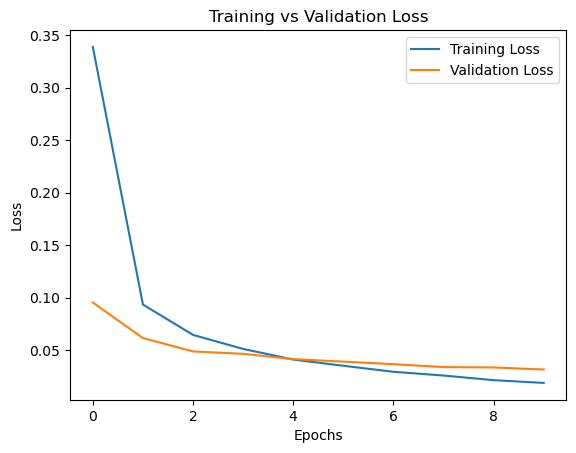

In [91]:
import matplotlib.pyplot as plt

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


### Evaluate on test data

In [92]:
# Explicit saving of the model for later use
model.save('models/MNIST.h5')

In [93]:
# Prediction
#from tensorflow.keras.models import load_model
#model = load_model('models/MNIST.h5')
model.evaluate(X_test_centered, Y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9926 - loss: 0.0229


[0.022917907685041428, 0.9926000237464905]

In [94]:
10000*(1-0.9922999739646912)

77.00026035308838

### Probabilities of each class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


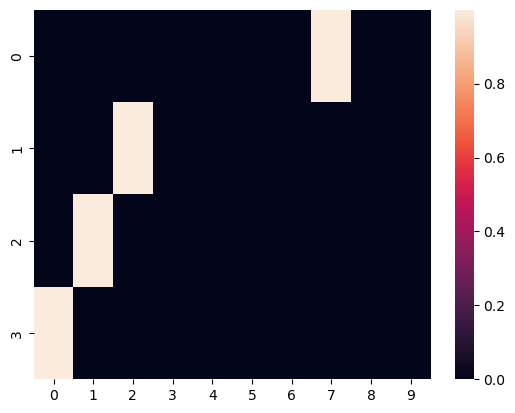

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


array([[3.2480810e-10, 3.1454743e-08, 6.9970653e-08, 3.3099826e-07,
        4.2330124e-12, 7.3333861e-10, 3.0760908e-13, 9.9999928e-01,
        4.1096862e-11, 1.7047918e-07],
       [9.0840479e-07, 5.2193514e-07, 9.9999857e-01, 2.4509367e-10,
        2.5665685e-12, 7.2691571e-13, 4.8133706e-09, 1.0693348e-10,
        3.9116377e-09, 3.3390944e-13],
       [2.3927264e-06, 9.9966621e-01, 6.9982052e-06, 5.1664351e-08,
        1.6758739e-05, 2.0239780e-07, 3.1806151e-06, 3.0207605e-04,
        1.8142885e-06, 4.0282333e-07],
       [9.9997640e-01, 5.3489049e-09, 9.4158240e-06, 3.0040610e-08,
        5.0330802e-09, 1.1500927e-07, 1.3119787e-05, 3.2694271e-07,
        3.7749342e-07, 2.6259787e-07]], dtype=float32)

In [95]:
# Predict with probabilities
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(model.predict(X_test_centered[:4,:]))
plt.show()
model.predict(X_test_centered[:4,:])

### Confusion matrix

In [96]:
from sklearn.metrics import confusion_matrix
import numpy as np
confusion_matrix(y_test,np.argmax(model.predict(X_test_centered), axis=1), labels = list(range(10)))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


array([[ 977,    0,    0,    0,    0,    0,    1,    1,    1,    0],
       [   0, 1131,    1,    0,    0,    0,    1,    2,    0,    0],
       [   0,    0, 1030,    0,    0,    0,    0,    2,    0,    0],
       [   0,    0,    1, 1003,    0,    3,    0,    2,    1,    0],
       [   0,    0,    1,    0,  972,    0,    4,    1,    1,    3],
       [   2,    0,    0,    5,    0,  883,    1,    0,    0,    1],
       [   3,    2,    0,    0,    1,    1,  950,    0,    1,    0],
       [   0,    2,    2,    0,    0,    0,    0, 1023,    0,    1],
       [   1,    0,    2,    3,    0,    2,    0,    1,  962,    3],
       [   3,    1,    0,    0,    3,    3,    0,    4,    0,  995]],
      dtype=int64)

### Activation of examples

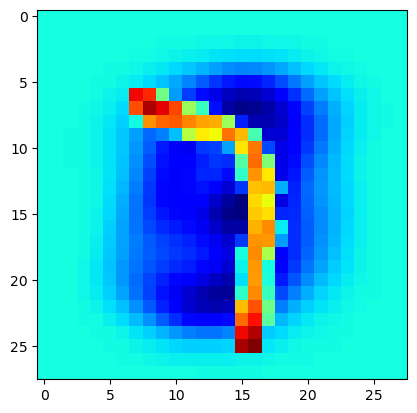

Ground truth: 7


<Figure size 4000x4000 with 0 Axes>

<Figure size 4000x4000 with 0 Axes>

In [97]:
sampleNum = 122
plt.figure()
plt.imshow(X_test_centered[sampleNum,:,:,0], interpolation='None', cmap='jet')
plt.show()
print("Ground truth: {}".format(y_test[sampleNum]))
plt.figure(figsize=(10, 10), dpi=400)

## keras API 


In [108]:
from tensorflow.keras.models import Model

# Ensure the model is "built"
_ = model.predict(X_test_centered[:1])

layer_name = "conv2d_4"  

intermediate_layer_model = Model(
    inputs=model.layers[0].input,
    outputs=model.get_layer(layer_name).output
)

sample = X_test_centered[:1]
intermediate_output = intermediate_layer_model.predict(sample)

print("Layer:", layer_name)
print("Activation shape:", intermediate_output.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Layer: conv2d_4
Activation shape: (1, 24, 24, 32)


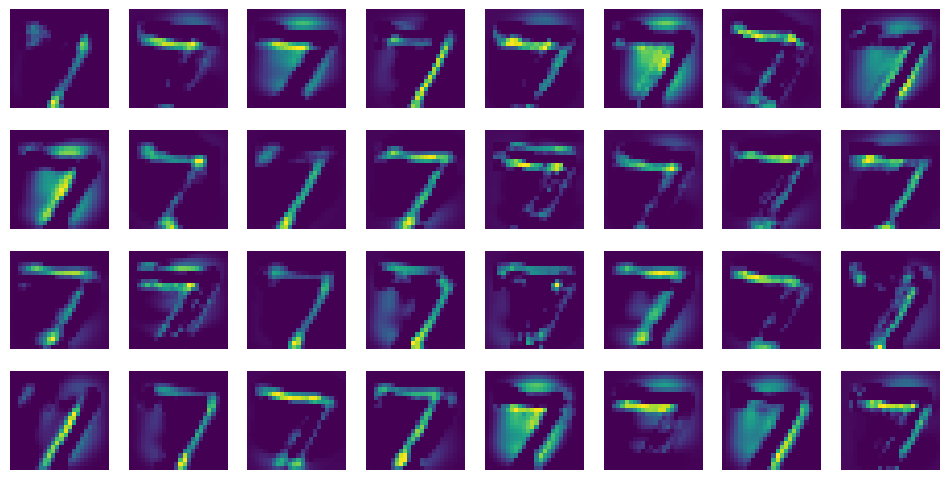

In [109]:
import matplotlib.pyplot as plt

activations = intermediate_output[0]  
num_filters = activations.shape[-1]

fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(activations[:, :, i], cmap="viridis")
    ax.axis("off")
plt.show()


### Weights from layers

(5, 5, 1, 32)


<Axes: >

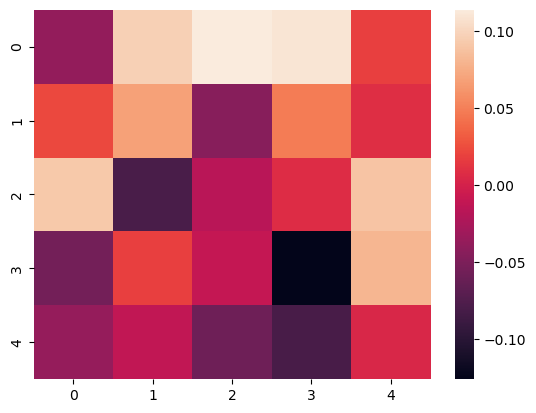

In [110]:
layer = 0
filter = 4
weights, biases = model.layers[layer].get_weights()
print(weights.shape)
sns.heatmap(weights[:,:,0,filter])

## Adverserial attacks
https://towardsdatascience.com/breaking-neural-networks-with-adversarial-attacks-f4290a9a45aa
- Neural networks can sometimes be fooled
- Simple image manipulation can cause mis-classification
  - Structured, invisible noise
  - Carefully placed stickers or tape on objects
  - Drawings of maximum activation patterns
- Can be limited using heavier computations
  - Added noise in image augmentation or weights
  - Train on soft targets (not 0/1)
  - Add adverserial examples in training

## Pipelining
- On-the-fly batch-wise pre-processing 
    - Read from disk
    - Convert to correct format
    - Reshape
    - Augment training set

In [111]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.2,
                            height_shift_range=0.2,
                            zoom_range=0.2,
                            rotation_range=30,
                            vertical_flip=False,
                            horizontal_flip=False)
datagen.fit(X_train_centered)
train_generator = datagen.flow(np.array(X_train_centered), np.array(Y_train), 
                               batch_size=64)
# flow_from_directory for direct import from image files (can include resizing)
# flow_from_dataframe for direct import based on a list of file names (numbering counted alphabetically)

## More augmentations:
https://github.com/albumentations-team/albumentations

### Applying the image generator

In [113]:
historyFlow = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=len(X_train_centered) // 64,
    validation_data=(X_valid_centered, Y_valid)
)


Epoch 1/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 50s 63ms/step - accuracy: 0.7776 - loss: 0.7164 - val_accuracy: 0.9793 - val_loss: 0.0782
Epoch 2/10
  1/781 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.9062 - loss: 0.2792

C:\Users\alfa\.conda\envs\dat300-env\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


781/781 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9062 - loss: 0.2792 - val_accuracy: 0.9786 - val_loss: 0.0801
Epoch 3/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.8872 - loss: 0.3670 - val_accuracy: 0.9828 - val_loss: 0.0597
Epoch 4/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8906 - loss: 0.4556 - val_accuracy: 0.9822 - val_loss: 0.0603
Epoch 5/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 61s 78ms/step - accuracy: 0.9122 - loss: 0.2848 - val_accuracy: 0.9842 - val_loss: 0.0514
Epoch 6/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9219 - loss: 0.2416 - val_accuracy: 0.9844 - val_loss: 0.0510
Epoch 7/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.9260 - loss: 0.2393 - val_accuracy: 0.9849 - val_loss: 0.0526
Epoch 8/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9375 - loss: 0.2117 - val_accuracy: 0.9851 - val_loss: 0.0526
Epoch 9/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - accuracy: 0.9361 - loss: 0.2064 - val_accuracy: 0.983

## Softmax activation
$$\sigma (a)_i = \frac{e^{a_i}}{\sum_{j=1}^K e^{a_j}} = h_i$$
- The activation of class $i$
- Exponent of each dummy input divided by the sum of exponents of all dummy inputs
  - Class activations sum to 1
- Only for output layer of a model

In [114]:
import tensorflow as tf
def round_tensor(x, dec):
    return np.round(tf.make_ndarray(tf.make_tensor_proto(x)), dec)

a = tf.constant([[-5, 0, 5, 6], [10, 0, 5, 6]], dtype=tf.float32)
b = tf.keras.activations.softmax(a)
round_tensor(b, 2)

array([[0.  , 0.  , 0.27, 0.73],
       [0.98, 0.  , 0.01, 0.02]], dtype=float32)

## ReLU activation
$\sigma(x) = max(0, x)$

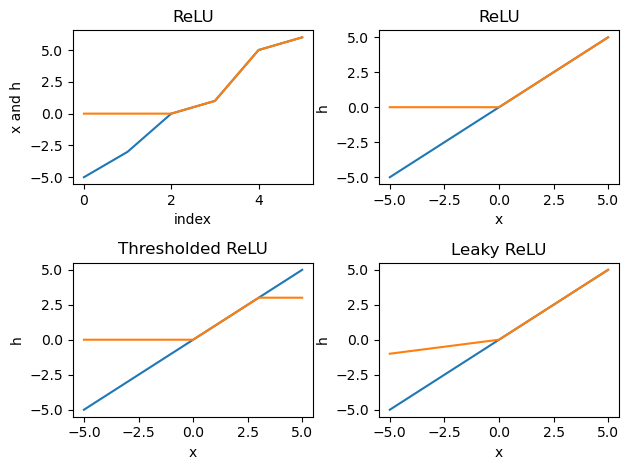

In [115]:
import matplotlib.pyplot as plt
x = tf.constant([-5, -3, 0, 1, 5, 6], dtype=tf.float32)
z = tf.constant(tf.range(-5,5, 0.01))
a = tf.keras.activations.relu(x); b = tf.keras.activations.relu(z) 
d = tf.keras.activations.relu(z, 0, 3) # Thresholded
e = tf.keras.activations.relu(z, 0.2)  # Leaky
plt.subplot(2, 2, 1); plt.plot(x); plt.plot(round_tensor(a, 3)); plt.xlabel('index'); plt.ylabel('x and h'); plt.title('ReLU')
plt.subplot(2, 2, 2); plt.plot(tf.range(-5,5, 0.01),z); plt.plot(tf.range(-5,5, 0.01),round_tensor(b, 3)); plt.xlabel('x'); plt.ylabel('h'); plt.title('ReLU')
plt.subplot(2, 2, 3); plt.plot(tf.range(-5,5, 0.01),z); plt.plot(tf.range(-5,5, 0.01),round_tensor(d, 3)); plt.xlabel('x'); plt.ylabel('h'); plt.title('Thresholded ReLU')
plt.subplot(2, 2, 4); plt.plot(tf.range(-5,5, 0.01),z); plt.plot(tf.range(-5,5, 0.01),round_tensor(e, 3)); plt.xlabel('x'); plt.ylabel('h'); plt.title('Leaky ReLU')
plt.tight_layout(); plt.show()

## Swish activation
$\sigma(x) = x \cdot sigmoid(x) = \frac{x}{1+e^{-x}}$

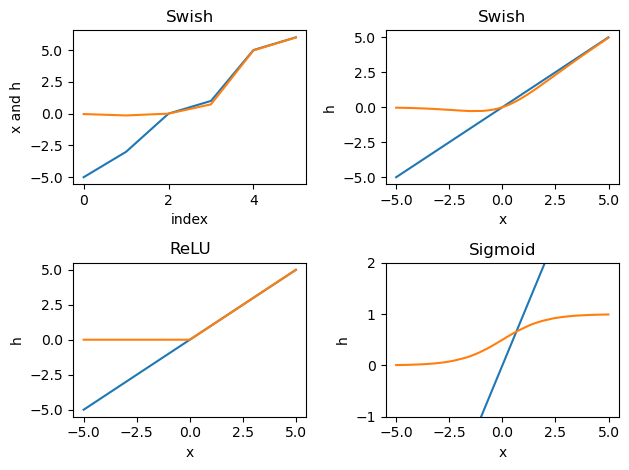

In [116]:
x = tf.constant([-5, -3, 0, 1, 5, 6], dtype=tf.float32)
z = tf.constant(tf.range(-5,5, 0.01))
a = tf.keras.activations.swish(x)
c = tf.keras.activations.swish(z)
f = tf.keras.activations.sigmoid(z)
plt.subplot(2, 2, 1); plt.plot(x); plt.plot(round_tensor(a, 3)); plt.xlabel('index'); plt.ylabel('x and h'); plt.title('Swish')
plt.subplot(2, 2, 2); plt.plot(tf.range(-5,5, 0.01),z); plt.plot(tf.range(-5,5, 0.01),round_tensor(c, 3)); plt.xlabel('x'); plt.ylabel('h'); plt.title('Swish')
plt.subplot(2, 2, 3); plt.plot(tf.range(-5,5, 0.01),z); plt.plot(tf.range(-5,5, 0.01),round_tensor(b, 3)); plt.xlabel('x'); plt.ylabel('h'); plt.title('ReLU')
plt.subplot(2, 2, 4); plt.plot(tf.range(-5,5, 0.01),z); plt.plot(tf.range(-5,5, 0.01),round_tensor(f, 3)); plt.xlabel('x'); plt.ylabel('h'); plt.title('Sigmoid'); plt.ylim([-1,2])
plt.tight_layout(); plt.show()

### Activation Function Comparison

| Function       | Positive side         | Negative side                 | Gradient behavior                  |
|----------------|----------------------|-------------------------------|------------------------------------|
| **ReLU**       | Passes input through | Zero output                   | Zero gradient for negatives        |
| **Leaky ReLU** | Passes input through | Small negative slope          | Constant small gradient for negatives |
| **Swish**      | Similar to input     | Small negative values allowed | Gradient smoothly varies with input |
